# 💵 How much better can we do with ARIMA?

Ah, you if remember from the previous try to run the holt-winters model on the stock data, we also did a **manual try** on the real world example for the RELIANCE data. Now, again we are going to do the same — but this time with a better approach ARIMA.

Let's get right into it, as there is *nothing new* to explain, we can code directly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from datetime import datetime, timedelta

plt.rcParams["figure.figsize"] = (20, 10)

import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error

In [2]:
# period of analysis
end = datetime.now()
start = end - timedelta(days=365 * 5)

stock = "RELIANCE.NS"
data = web.DataReader(stock, 'yahoo', start, end)

Start: Year, Month, Day, Time
2017-08-15 18:18:49.567754


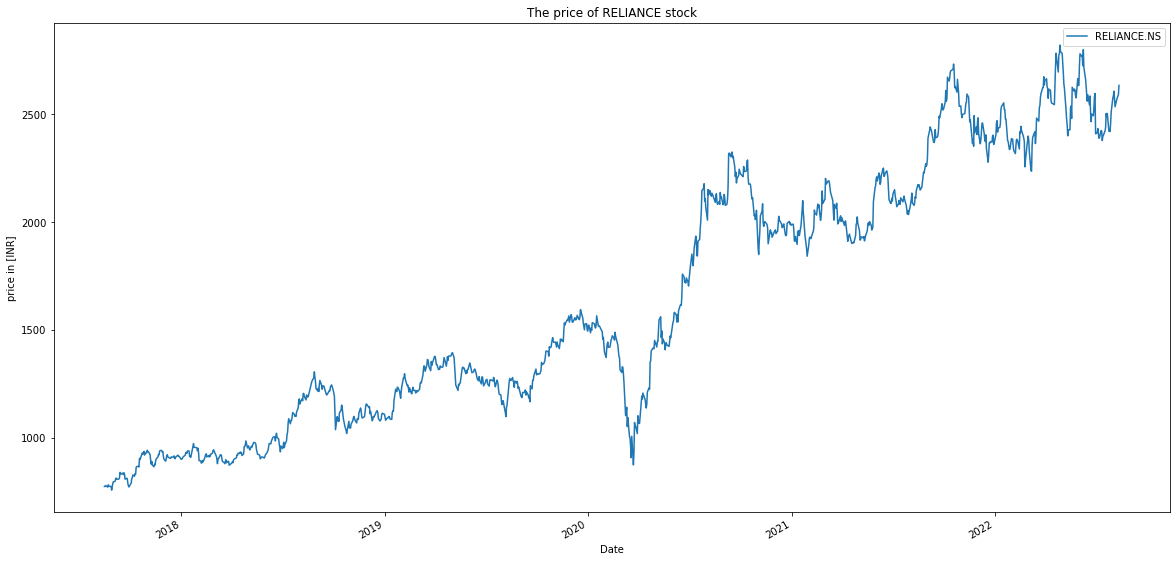

In [3]:
# nice looking timeseries (DataFrame to panda Series)
data = data.reset_index()
data = pd.Series(data.Close.values, data.Date)

print("Start: Year, Month, Day, Time")
print(str(start))
data.plot(label=stock);
plt.legend()
plt.ylabel('price in [INR]')

plt.title("The price of RELIANCE stock")
plt.show();

Please don't worry about the code above, it is just to fetch the RELIANCE data till now. Nothing else. 

In [4]:
# The train and test split
train_idx = data.iloc[:-31].index
test_idx = data.iloc[-31:].index

In [5]:
# Check the R2 and MAE
def get_metrics(true, forecast):
    print("MAPE:", round(mean_absolute_percentage_error(true, forecast) * 100, 4), "%")
    print("MAE:", mean_absolute_error(true, forecast))
    print("RMSE:", mean_squared_error(true, forecast, squared=False))
    print("R2:", r2_score(true, forecast))

## 🔫  Gun is loaded. Let's shoot. (Non violently; of course.)

#### 1️⃣ Simple model, initial parameters

In [7]:
initial_model = pm.auto_arima(data[train_idx], 
                             seasonal=False,
                             stepwise=True,
                             trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11760.492, Time=3.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11770.988, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11772.765, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11772.779, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11771.596, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11774.706, Time=1.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11775.010, Time=1.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11762.390, Time=3.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11762.377, Time=3.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11774.980, Time=0.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11774.683, Time=2.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11775.221, Time=1.95 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11764.350, Time=4.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=11760.920, Time=1.56 sec

Best model:  ARIMA

**Important notes:**
- See that here we have ***not*** taken the seasonality into an account
- That is simple because the stock are not dependent on the seasonal values
- They might be, as of Diwali and other festivals tend to go up or down but for the initial model, we would like to make it non-seasonal only.

**The model:**
- The model that we have received is `ARIMA(2, 1, 2)`
- That means, our data might be dependent on the past 2 days data
- The one day differencing makes the data stationary, even we can check these assumptions by doing the tests.


####  Some predictions

In [16]:
def print_error(true, pred):
    RMSE = mean_squared_error(true, pred, squared=False)
    R2 = r2_score(true, pred)
    print("RMSE:", RMSE)
    print("R2:", R2)

In [8]:
insample_predictions = initial_model.predict_in_sample(start=1, end=-1)

In [11]:
outsample_predictions, conf_interval = initial_model.predict(31, return_conf_int=True)

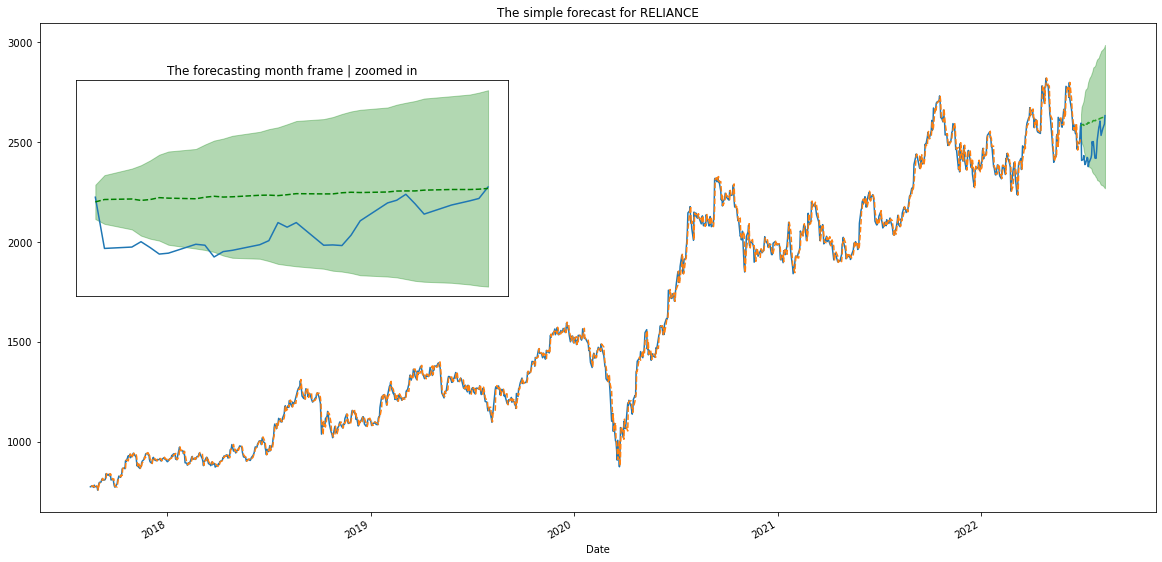

In [15]:
main_axes = plt.axes()
small_axes = plt.axes([.15,.5,.3,.3])

data.plot(ax=main_axes)

insample_predictions = pd.Series(insample_predictions, index=train_idx[1:])
insample_predictions.plot(ax=main_axes, ls='dashed')

outsample_predictions = pd.Series(outsample_predictions, index=test_idx)
outsample_predictions.plot(ax=main_axes, ls='dashed')

data[test_idx].plot(ax=small_axes)
outsample_predictions.plot(ax=small_axes, ls='dashed', color="green")

main_axes.fill_between(test_idx, 
                 conf_interval[:, 0],
                 conf_interval[:, 1],
                 alpha=0.3,
                 color="green")

small_axes.fill_between(test_idx, 
                 conf_interval[:, 0],
                 conf_interval[:, 1],
                 alpha=0.3,
                 color="green")

main_axes.set(title="The simple forecast for RELIANCE");
small_axes.set(yticks=[], xticks=[], xlabel='',
               title="The forecasting month frame | zoomed in");

In [17]:
get_metrics(data[test_idx], outsample_predictions)

MAPE: 5.1829 %
MAE: 126.26269553980035
RMSE: 143.7458426110383
R2: -2.2745460092038834


Recall, when we tried Holt winter's initial model, we received the `5.4912%` MAPE. Here it is ~0.3% better.

### Checking the ACF and PACF
This will make sure that the auto-ARIMA makes sense.

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

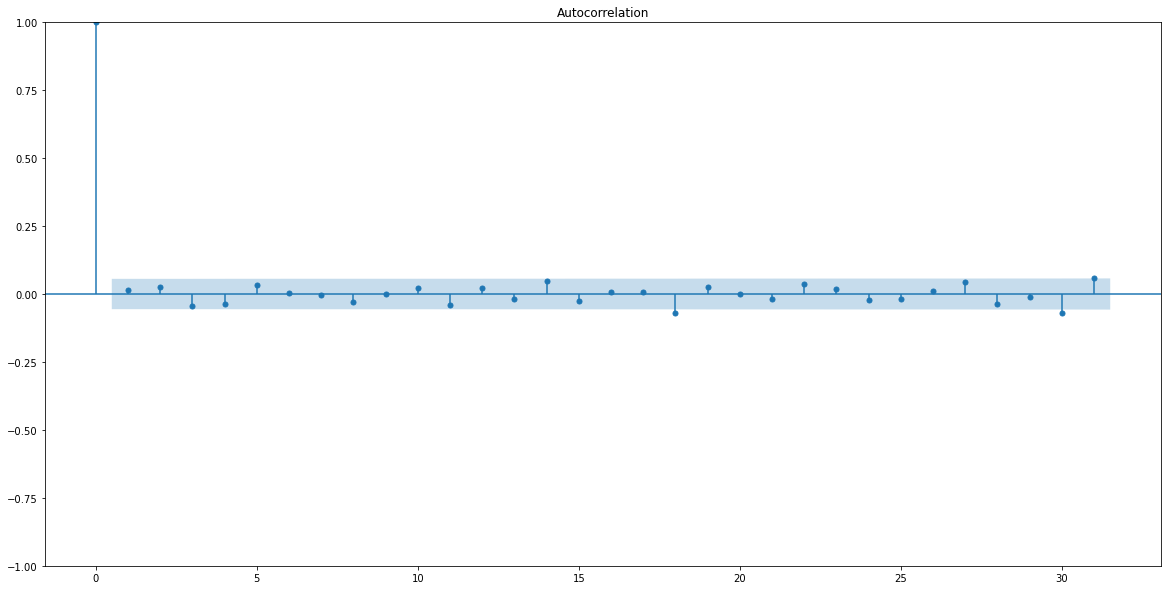

In [31]:
# checking the pacf/acf on the differenced data — which makes data stationary
# that lets the acf/pacf to work properly on the stationary data
plot_acf(data.diff().dropna());

We see some spikes on 19 and 29 but they are not much significant. So we can say that `p` and should be 0. Here, in auto_arima, it has suggested 2 though.

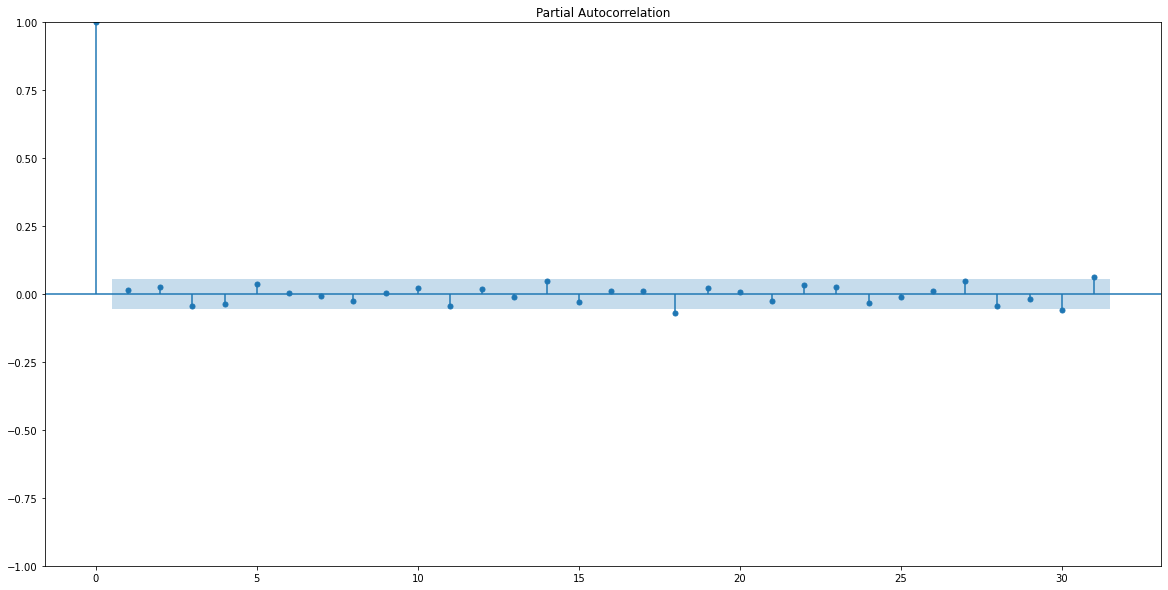

In [33]:
plot_pacf(data.diff().dropna(), method="yw");

Again, the same thing. Here we don't see any significan PACF which can suggest us that the `q` can be that value. Thus, if we were to model this out, we could have kept that as 0 as well.

# 

# Not great,
I know. I am ending this book here. I was trying the full grid seach for it on the other params as well but that was taking much much time. That was insane. Thus, I am going to proceed forward instead of wasting my time and energy in here. 

See you there.